In [1]:
 # Goal is to predict which hosts would be successful in getting customers/hosts through Airbnb (online marketplace)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from scipy.stats import zscore
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# from google.colab import files
# uploaded = files.upload()
path = 'https://raw.githubusercontent.com/Cherry301/-UH-SPE-ML-Bootcamp-Team4-Project3/master/AB_NYC_2019.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [6]:
print(df.shape)
print(df.dtypes)

(48895, 16)
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


In [7]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
df = df.dropna()
print(df.shape)

(38821, 16)


In [9]:
# verify that there are no nan values in df
df.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
df.nunique()

id                                38821
name                              38253
host_id                           30232
host_name                          9885
neighbourhood_group                   5
neighbourhood                       218
latitude                          17436
longitude                         13639
room_type                             3
price                               581
minimum_nights                       89
number_of_reviews                   393
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

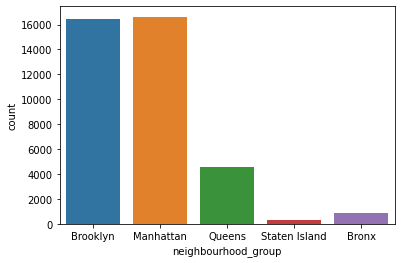

In [11]:
# counts how many times the unique values of the "neighborhood_group" column show up using seaborn
sns.countplot(x= 'neighbourhood_group', data= df)

Seems to be a lot of available space for Airbnb accommodations in the neighborhoods of **Brooklyn** and **Manhattan** 

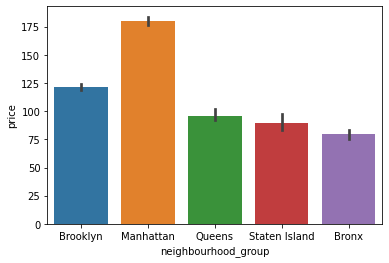

In [12]:
# shows the prices of airbnb in the "neighborhood_group"
sns.barplot(x= 'neighbourhood_group', y= 'price', data= df)

The Airbnb have the highest prices in **Manhattan**, assuming people are willing to pay more for Manhattan Airbnb

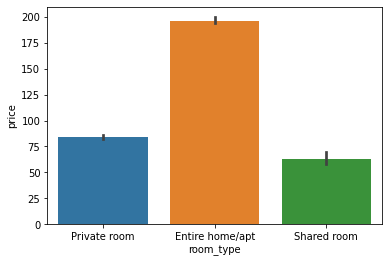

In [13]:
sns.barplot(x= 'room_type', y= 'price', data= df)

People are willing to pay more money for accommadations that are **Entire home/apt room_type**

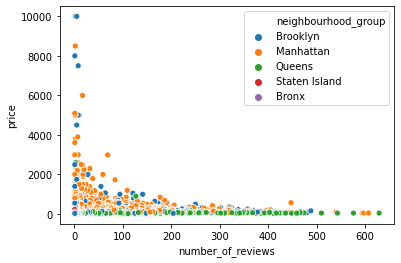

In [14]:
# seems to not correlate between number of reviews and price
sns.scatterplot(x= 'number_of_reviews', y= 'price', data= df, hue= 'neighbourhood_group')

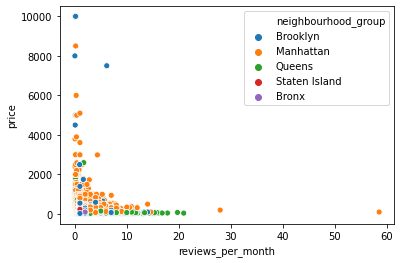

In [15]:
# seems to not correlate between reviews per month and price, ex. Queens had 20 reviews per month at zero price
sns.scatterplot(x= 'reviews_per_month', y= 'price', data= df, hue= 'neighbourhood_group')

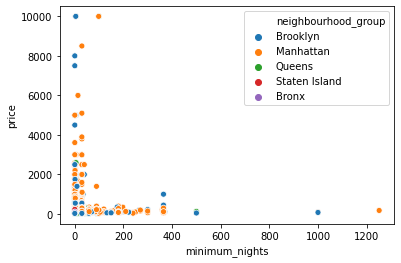

In [16]:
sns.scatterplot(x= 'minimum_nights', y= 'price', data= df, hue= 'neighbourhood_group')

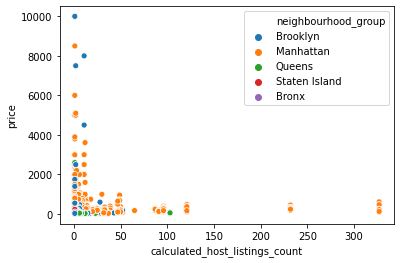

In [17]:
sns.scatterplot(x= 'calculated_host_listings_count', y= 'price', data= df, hue= 'neighbourhood_group')

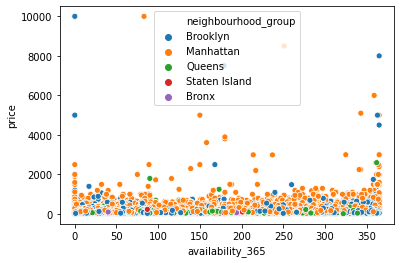

In [18]:
sns.scatterplot(x= 'availability_365', y= 'price', data= df, hue= 'neighbourhood_group')

# Preparing the data for analysis

Converting 'last_review' variable into days since last review from a given date (today)

In [19]:
def days_from_today(date_string, today_string = '2020-08-28'):
  import datetime
  if type(date_string) == str:
    date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    today_obj = datetime.datetime.strptime(today_string, '%Y-%m-%d')
    d = today_obj - date_obj
    return int(d.days)
  else:
    return None

In [20]:
df['Days_since_last_review'] = df['last_review'].map(days_from_today)


Removing columns that are not expected to be a factor in pricing: 'id', 'name', 'host_id', 'host_name', 'latitude', 'longitude', 'last_review'

In [21]:
df_red = df.drop(['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude', 'last_review'], axis = 1)

In [22]:
df_red.isna().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Days_since_last_review            0
dtype: int64

Removing outliers in the price variable

In [23]:
df_red['price_zscore'] = pd.DataFrame(df_red['price']).apply(zscore)

In [24]:
df_red = df_red[abs(df_red['price_zscore']) < 2]

In [25]:
df_red.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Days_since_last_review,price_zscore
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,679,0.033846
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,465,0.419648
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,420,-0.270734
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,648,-0.316421
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129,433,0.292740


In [26]:
df_red = df_red.drop(['price_zscore'], axis = 1)

Splitting the (predictor) data into categorical and numerical data

In [27]:

df_categorical = df_red.drop([ 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'Days_since_last_review'], axis = 1)

In [28]:
df_num = df_red.drop(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',], axis = 1)

Normalizing numerical data

In [29]:
mean = df_num.mean(axis=0)
df_num -= mean
std = df_num.std(axis=0)
df_num /= std

df_num -= mean
df_num /= std

Dummifying categorical variables

In [30]:
df_categorical_dum = pd.get_dummies(df_categorical, columns = [ 'neighbourhood_group', 'neighbourhood', 'room_type'])

In [31]:
df_categorical_dum.shape

(38229, 226)

In [32]:
df_num.shape

(38229, 6)

Finally, concatenating our predictors and assigning y to make our data ready:

In [33]:
X = pd.concat([df_num, df_categorical_dum],axis = 1)
y = df_red['price']


# Neural network modeling to predict price using Keras library


Splitting into training and testing datasets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # 50% training and 50% test

**A first run (base case) of a model with 3 hidden layers and some regularization as well:**

In [35]:
  from keras import models
  from keras import layers
  from tensorflow.keras import regularizers
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(16, activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3),
                          bias_regularizer=regularizers.l2(1e-3),
                          activity_regularizer=regularizers.l2(1e-4)))
  model.add(layers.Dense(16, activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
                          bias_regularizer=regularizers.l2(1e-3),
                          activity_regularizer=regularizers.l2(1e-4))) ##
  model.add(layers.Dense(16, activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
                          bias_regularizer=regularizers.l2(1e-3),
                          activity_regularizer=regularizers.l2(1e-4))) ##
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [36]:
history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs= 10, batch_size=1, verbose=1)



Epoch 1/10
19114/19114 [==============================] - 31s 2ms/step - loss: 4602.9653 - mae: 44.4784 - val_loss: 4130.8721 - val_mae: 42.4521
Epoch 2/10
19114/19114 [==============================] - 31s 2ms/step - loss: 4204.8989 - mae: 42.2955 - val_loss: 4118.4443 - val_mae: 41.8463
Epoch 3/10
19114/19114 [==============================] - 31s 2ms/step - loss: 4189.6309 - mae: 42.1794 - val_loss: 4076.5381 - val_mae: 41.8309
Epoch 4/10
19114/19114 [==============================] - 31s 2ms/step - loss: 4171.0903 - mae: 41.8965 - val_loss: 4106.4551 - val_mae: 40.8633
Epoch 5/10
19114/19114 [==============================] - 30s 2ms/step - loss: 4159.3804 - mae: 41.7443 - val_loss: 4056.5015 - val_mae: 42.2939
Epoch 6/10
19114/19114 [==============================] - 31s 2ms/step - loss: 4186.5186 - mae: 41.8735 - val_loss: 4169.0474 - val_mae: 41.1127
Epoch 7/10
19114/19114 [==============================] - 32s 2ms/step - loss: 4183.7700 - mae: 41.9313 - val_loss: 4106.9189 - va

In [37]:
mse, mae = model.evaluate(X_test, y_test, verbose=0)

In [38]:
print(mae)


40.80584716796875


Mean average error is high, it is possible that for some cases the error is very high but as seen in histogram below most errors are less than 15

In [39]:
y_pred = model.predict(X_test)
y_actual = np.array(y_test)
error = abs(y_actual - y_pred.reshape(-1) )


Text(0, 0.5, 'Cumulative')

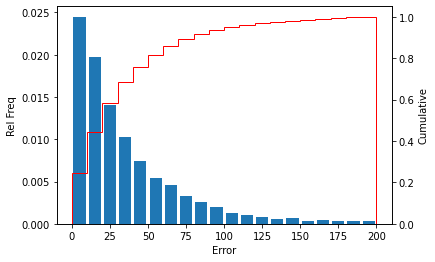

In [40]:
fig, ax = plt.subplots()
ax.hist(error, bins = np.linspace(0,200,21), density = True, align = 'mid', rwidth=0.8)
ax.set_xlabel('Error')
ax.set_ylabel('Rel Freq')
ax1 = ax.twinx()
ax1.hist(error, bins=np.linspace(0,200,21), histtype='step', color = 'r',  density = True, cumulative=True)
ax1.set_ylabel('Cumulative')



Most errors are less than 15 USD

**Attempting a simpler network with only 1 hidden layer and no regularization**


In [41]:
model1 = models.Sequential()
model1.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(1))
model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [42]:
history = model1.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs= 10, batch_size=1, verbose=1)

Epoch 1/10
19114/19114 [==============================] - 28s 1ms/step - loss: 5145.2759 - mae: 46.8858 - val_loss: 4194.1196 - val_mae: 42.3624
Epoch 2/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4200.0190 - mae: 42.1167 - val_loss: 4148.9360 - val_mae: 43.7628
Epoch 3/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4179.4741 - mae: 41.9155 - val_loss: 4117.6475 - val_mae: 43.3472
Epoch 4/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4164.5371 - mae: 41.8607 - val_loss: 4103.7036 - val_mae: 41.7739
Epoch 5/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4150.1074 - mae: 41.6731 - val_loss: 4105.3413 - val_mae: 41.2440
Epoch 6/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4135.9028 - mae: 41.5924 - val_loss: 4071.1235 - val_mae: 42.6906
Epoch 7/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4123.7842 - mae: 41.4821 - val_loss: 4057.7671 - va

In [43]:
mse, mae = model1.evaluate(X_test, y_test, verbose=1)
print(mae)

598/598 [==============================] - 1s 1ms/step - loss: 4053.2383 - mae: 42.0416
42.041629791259766


In [44]:
y_pred = model1.predict(X_test)
y_actual = np.array(y_test)
error = abs(y_actual - y_pred.reshape(-1) )

Text(0, 0.5, 'Cumulative')

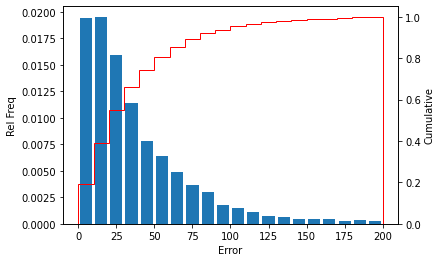

In [45]:
fig, ax = plt.subplots()
ax.hist(error, bins = np.linspace(0,200,21), density = True, align = 'mid', rwidth=0.8)
ax.set_xlabel('Error')
ax.set_ylabel('Rel Freq')
ax1 = ax.twinx()
ax1.hist(error, bins=np.linspace(0,200,21), histtype='step', color = 'r',  density = True, cumulative=True)
ax1.set_ylabel('Cumulative')

Almost the same as in previous case, we will adopt simpler case

**Attemting simpler case with sigmoid activation function**

In [46]:
model2 = models.Sequential()
model2.add(layers.Dense(16, activation='sigmoid', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(16, activation='sigmoid'))
model2.add(layers.Dense(1))
model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [47]:
history = model2.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs= 10, batch_size=1, verbose=1)

Epoch 1/10
19114/19114 [==============================] - 28s 1ms/step - loss: 10238.5215 - mae: 69.6412 - val_loss: 5632.0107 - val_mae: 46.8126
Epoch 2/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4885.5078 - mae: 43.9793 - val_loss: 4450.8281 - val_mae: 42.6061
Epoch 3/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4352.1890 - mae: 42.0294 - val_loss: 4273.4019 - val_mae: 41.8087
Epoch 4/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4231.0264 - mae: 41.6485 - val_loss: 4234.4429 - val_mae: 41.0546
Epoch 5/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4180.3057 - mae: 41.5592 - val_loss: 4137.2573 - val_mae: 42.1406
Epoch 6/10
19114/19114 [==============================] - 29s 2ms/step - loss: 4158.9111 - mae: 41.4334 - val_loss: 4127.5264 - val_mae: 42.4805
Epoch 7/10
19114/19114 [==============================] - 28s 1ms/step - loss: 4141.6675 - mae: 41.4690 - val_loss: 4192.0747 - v

In [48]:
mse, mae = model2.evaluate(X_test, y_test, verbose=0)
print(mae)

41.741943359375


In [49]:
y_pred = model2.predict(X_test)
y_actual = np.array(y_test)
error = abs(y_actual - y_pred.reshape(-1) )

Text(0, 0.5, 'Cumulative')

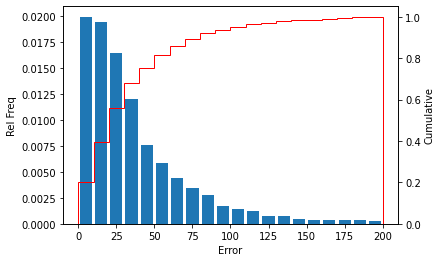

In [50]:
fig, ax = plt.subplots()
ax.hist(error, bins = np.linspace(0,200,21), density = True, align = 'mid', rwidth=0.8)
ax.set_xlabel('Error')
ax.set_ylabel('Rel Freq')
ax1 = ax.twinx()
ax1.hist(error, bins=np.linspace(0,200,21), histtype='step', color = 'r',  density = True, cumulative=True)
ax1.set_ylabel('Cumulative')

No improvement is observed

**Attempting base case with higher density of layers**

In [51]:
  model3 = models.Sequential()
  model3.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
  model3.add(layers.Dense(512, activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.l2(1e-4),
                          activity_regularizer=regularizers.l2(1e-5)))
  model3.add(layers.Dense(512, activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5))) ##
  model3.add(layers.Dense(512, activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5))) ##
  model3.add(layers.Dense(1))
  model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
history = model3.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs= 10, batch_size=1, verbose=1)

In [ ]:
mse, mae = model3.evaluate(X_test, y_test, verbose=0)
print(mae)

33.18612289428711


In [ ]:
y_pred = model3.predict(X_test)
y_actual = np.array(y_test)
error = abs(y_actual - y_pred.reshape(-1) )

Text(0, 0.5, 'Cumulative')

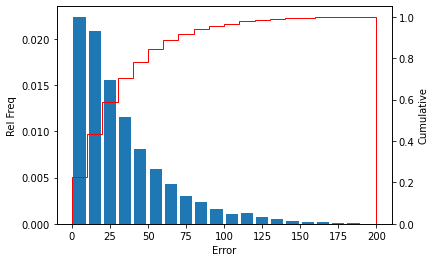

In [ ]:
fig, ax = plt.subplots()
ax.hist(error, bins = np.linspace(0,200,21), density = True, align = 'mid', rwidth=0.8)
ax.set_xlabel('Error')
ax.set_ylabel('Rel Freq')
ax1 = ax.twinx()
ax1.hist(error, bins=np.linspace(0,200,21), histtype='step', color = 'r',  density = True, cumulative=True)
ax1.set_ylabel('Cumulative')

No improvement is observed. In the following section we will bin price into discrete categories and run a model to predict the range/bin

**Binning/categorizing the dependent variable 'price'**

In [ ]:
cut_prices = pd.qcut(y, q = 5, labels = ['very cheap', 'cheap', 'fair', 'expensive', 'very expensive'])

In [ ]:
cut_prices

0             expensive
1        very expensive
3                  fair
4                 cheap
5        very expensive
              ...      
48782         expensive
48790        very cheap
48799    very expensive
48805              fair
48852        very cheap
Name: price, Length: 36744, dtype: category
Categories (5, object): [very cheap < cheap < fair < expensive < very expensive]

In [ ]:
cut_prices = pd.get_dummies(cut_prices)

In [ ]:
X = pd.concat([df_num, df_categorical_dum],axis = 1)
y1 = cut_prices

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.5) # 50% training and 50% test

In [ ]:
from keras import models
from keras import layers

model4 = models.Sequential()
model4.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model4.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),
                          bias_regularizer=regularizers.l2(1e-2),
                          activity_regularizer=regularizers.l2(1e-3) ))
model4.add(layers.Dense(5, activation='softmax'))

In [ ]:
model4.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model4.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.4191 - accuracy: 0.4328
Epoch 2/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2518 - accuracy: 0.4553
Epoch 3/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2346 - accuracy: 0.4576
Epoch 4/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2263 - accuracy: 0.4587
Epoch 5/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2204 - accuracy: 0.4626
Epoch 6/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2168 - accuracy: 0.4657
Epoch 7/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2132 - accuracy: 0.4621
Epoch 8/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2094 - accuracy: 0.4678
Epoch 9/100
1149/1149 [==============================] - 1s 1ms/step - loss: 1.2062 - accuracy: 0.4704
Epoch 10/100
1149/1149 [==============================] - 1s 1ms/step - l

In [ ]:
test_loss, test_acc = model4.evaluate(X_test, y_test)

575/575 [==============================] - 1s 921us/step - loss: 1.2068 - accuracy: 0.4746


We only obtain an accuracy of about 47.5%. This is better than 20% expected by chance alone, however we consider it to be very poor